# Data (from week 1) needed for our week 2 response
## Import

In [152]:
import xarray as xr
import pandas as pd
import rasterio
from rasterio.mask import mask
from rasterio.transform import from_bounds
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import seaborn as sns

## Init

In [153]:
main_data_folder = "data/"
gadm_filepath = main_data_folder + "gadm_410_europe.gpkg"
country_code = "ESP" # Spain
cityname = "Madrid"

In [154]:
gadm_gdf = gpd.read_file(gadm_filepath)

print(f"Number of rows in GADM: {len(gadm_gdf)}")
filtered_gadm_gdf = gadm_gdf[(gadm_gdf.GID_0 == country_code) & (gadm_gdf.NAME_2 == cityname)]

print(f"Number of rows in GADM after filtering: {len(filtered_gadm_gdf)}")
filtered_gadm_gdf.head()

Number of rows in GADM: 106252
Number of rows in GADM after filtering: 181


,UID,GID_0,NAME_0,GID_1,NAME_1,ENGTYPE_1,GID_2,NAME_2,ENGTYPE_2,GID_3,...,ENGTYPE_3,GID_4,NAME_4,ENGTYPE_4,GID_5,NAME_5,ENGTYPE_5,COUNTRY,CONTINENT,geometry
90995,305016,ESP,Spain,ESP.8_1,Comunidad de Madrid,Autonomous Community,ESP.8.1_1,Madrid,Province,ESP.8.1.1_1,...,Comarca,ESP.8.1.1.1_1,Alameda del Valle,Municipality,,,,Spain,Europe,"MULTIPOLYGON (((-3.89887 40.95908, -3.89501 40..."
90996,305017,ESP,Spain,ESP.8_1,Comunidad de Madrid,Autonomous Community,ESP.8.1_1,Madrid,Province,ESP.8.1.1_1,...,Comarca,ESP.8.1.1.2_1,Berzosa del Lozoya,Municipality,,,,Spain,Europe,"MULTIPOLYGON (((-3.4963 40.99471, -3.49791 40...."
90997,305018,ESP,Spain,ESP.8_1,Comunidad de Madrid,Autonomous Community,ESP.8.1_1,Madrid,Province,ESP.8.1.1_1,...,Comarca,ESP.8.1.1.3_1,Braojos,Municipality,,,,Spain,Europe,"MULTIPOLYGON (((-3.70555 41.07751, -3.69502 41..."
90998,305019,ESP,Spain,ESP.8_1,Comunidad de Madrid,Autonomous Community,ESP.8.1_1,Madrid,Province,ESP.8.1.1_1,...,Comarca,ESP.8.1.1.4_1,Buitrago del Lozoya,Municipality,,,,Spain,Europe,"MULTIPOLYGON (((-3.6451 40.95414, -3.65023 40...."
90999,305020,ESP,Spain,ESP.8_1,Comunidad de Madrid,Autonomous Community,ESP.8.1_1,Madrid,Province,ESP.8.1.1_1,...,Comarca,ESP.8.1.1.5_1,Bustarviejo,Municipality,,,,Spain,Europe,"MULTIPOLYGON (((-3.79052 40.84676, -3.786 40.8..."


In [155]:
one_city_gdf = filtered_gadm_gdf.dissolve()

one_city_gdf.head()

,geometry,UID,GID_0,NAME_0,GID_1,NAME_1,ENGTYPE_1,GID_2,NAME_2,ENGTYPE_2,...,NAME_3,ENGTYPE_3,GID_4,NAME_4,ENGTYPE_4,GID_5,NAME_5,ENGTYPE_5,COUNTRY,CONTINENT
0,"MULTIPOLYGON (((-4.55042 40.20185, -4.57506 40...",305016,ESP,Spain,ESP.8_1,Comunidad de Madrid,Autonomous Community,ESP.8.1_1,Madrid,Province,...,n.a. (175),Comarca,ESP.8.1.1.1_1,Alameda del Valle,Municipality,,,,Spain,Europe


## ERA-5 Land


In [156]:
era5_data_folder = main_data_folder + "derived-era5-land-daily-statistics/"

variable2statistic = {
    "2m_temperature": "daily_maximum",
    "total_precipitation": "daily_mean",
    "10m_u_component_of_wind": "daily_mean",
    "10m_v_component_of_wind": "daily_mean",
}

variable2datavar = {
    "2m_temperature": "t2m",
    "total_precipitation": "tp",
    "10m_u_component_of_wind": "u10",
    "10m_v_component_of_wind": "v10",
}
origin_crs = "EPSG:4326"

variable = "2m_temperature"
year = 2020
statistic = variable2statistic[variable]
datavar = variable2datavar[variable]

filepath = f"{era5_data_folder}{year}_{variable}_{statistic}.nc"
ds = xr.open_dataset(filepath)
print(ds)
lat, lon = 39.8960, -2.4876
filepaths = glob(f"{era5_data_folder}*_{variable}_{statistic}.nc")
ds = xr.open_mfdataset(filepaths, combine="by_coords")


<xarray.Dataset> Size: 338MB
Dimensions:     (valid_time: 366, latitude: 350, longitude: 660)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
  * latitude    (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number      int64 8B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 338MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-03T16:43 GRIB to CDM+CF via cfgrib-0.9.1...


## NDVI

In [157]:
ndvi_data_folder = main_data_folder + "sentinel2_ndvi/"

def quarter2timeperiod(year, quarter):
    if quarter == 1:
        return f"{year-1}-12-01_{year}-03-01"
    elif quarter == 2:
        return f"{year}-03-01_{year}-06-01"
    elif quarter == 3:
        return f"{year}-06-01_{year}-09-01"
    elif quarter == 4:
        return f"{year}-09-01_{year}-12-01"
    else:
        raise ValueError("quarter must be in 1, 2, 3, 4")


In [158]:
available_years = [2020, 2021, 2022, 2023]
available_quarters = [1, 2, 3, 4]
year = 2020
quarter = 3
timeperiod = quarter2timeperiod(year, quarter)

filepath  = f"{ndvi_data_folder}ndvi_{timeperiod}.tif"
day = pd.to_datetime(f"{year}-06-01")


In [159]:
def convert_ndvi_to_real_scale(ndvi_img, out_meta):
    # The NDVI is stored in int8 format on a 0/254 scale, and nodata is 255.
    # This function converts it to a float format on a -1/1 scale, and replace nodata with np.nan.
    ndvi_img = ndvi_img.astype(float)
    ndvi_img[ndvi_img == out_meta["nodata"]] = np.nan
    ndvi_img = ndvi_img / 254 * 2 - 1
    return ndvi_img

def get_out_image_and_metadata(filepath, one_city_gdf):
    with rasterio.open(filepath) as src:
        one_city_gdf_in_good_crs = one_city_gdf.to_crs(src.crs)
        city_geometry = [one_city_gdf_in_good_crs.geometry.iloc[0]]
        out_image, out_transform = mask(src, city_geometry, crop=True)
        out_meta = src.meta

        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        real_out_image = convert_ndvi_to_real_scale(out_image, out_meta)

    return real_out_image, out_meta

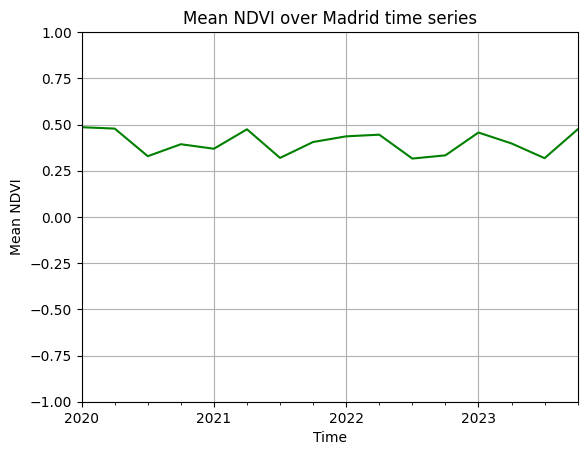

In [160]:
mean_ndvi_time_series = pd.Series(dtype=float)
for year in available_years:
    for quarter in available_quarters:
        timeperiod = quarter2timeperiod(year, quarter)
        filepath  = f"{ndvi_data_folder}ndvi_{timeperiod}.tif"
        date = pd.to_datetime(timeperiod.split("_")[1])
        current_real_out_image, _ = get_out_image_and_metadata(filepath, one_city_gdf)
        current_mean_ndvi = np.nanmean(current_real_out_image[0])
        mean_ndvi_time_series.loc[date] = current_mean_ndvi

mean_ndvi_time_series = mean_ndvi_time_series.sort_index()

plt.figure()
mean_ndvi_time_series.plot(color='green')
plt.title(f"Mean NDVI over {cityname} time series")
plt.ylabel("Mean NDVI")
plt.xlabel("Time")
plt.ylim(-1, 1)
plt.grid()
plt.show()

## Reprojection

In [161]:
da = ds[datavar].sel(valid_time=day)
real_out_image, out_meta = get_out_image_and_metadata(filepath, one_city_gdf)

origin_transform = from_bounds(
    ds.longitude.min().item(),
    ds.latitude.min().item(),
    ds.longitude.max().item(),
    ds.latitude.max().item(),
    len(ds.longitude),
    len(ds.latitude)
)
origin_crs = "EPSG:4326"

target_transform = out_meta["transform"]
target_crs = out_meta["crs"]

reprojected_da = da.rio.write_crs(origin_crs).rio.reproject(
    dst_crs=target_crs,
    shape=(out_meta["height"], out_meta["width"]),
    transform=target_transform,
)

## Stations



In [162]:
eca_tx_datafolder = main_data_folder + "ECA_blend_tx/"
stations_filepath = eca_tx_datafolder + "stations.txt"
def dms_to_decimal(dms_str):
    # This function converts a DMS (Degrees:Minutes:Seconds) string to decimal degrees.
    dms_str = dms_str.strip()
    
    sign = 1 if dms_str[0] == '+' else -1
    
    dms_str = dms_str[1:]
    
    parts = dms_str.split(':')
    degrees = float(parts[0])
    minutes = float(parts[1])
    seconds = float(parts[2])
    
    decimal = sign * (degrees + minutes/60 + seconds/3600)
    
    return decimal

In [163]:
stations_df = pd.read_csv(
    stations_filepath,
    skiprows=17,
    skipinitialspace=True
)

stations_df['LAT_decimal'] = stations_df['LAT'].apply(dms_to_decimal)
stations_df['LON_decimal'] = stations_df['LON'].apply(dms_to_decimal)

stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df['LON_decimal'], stations_df['LAT_decimal']),
    crs="EPSG:4326" # (WGS84, adequate for lat/lon coordinates)
).drop(columns=['LAT', 'LON', 'LAT_decimal', 'LON_decimal'])

one_city_gdf.to_crs(stations_gdf.crs, inplace=True) # Use same CRS for spatial operations

stations_in_city_gdf = stations_gdf[stations_gdf.within(one_city_gdf.geometry.iloc[0])]
selected_station = stations_in_city_gdf.iloc[9]
selected_station_gdf = gpd.GeoDataFrame([selected_station], crs=stations_in_city_gdf.crs)
selected_station_STAID = selected_station['STAID']

station_data_filepath = eca_tx_datafolder + f"TX_STAID{selected_station_STAID:06d}.txt"

station_data_df = pd.read_csv(
    station_data_filepath,
    skiprows=20,
    skipinitialspace=True
)

valid_data_df = station_data_df[station_data_df['Q_TX'] == 0].copy() # Q_TX is the quality code for TX (0='valid')
valid_data_df['DATE'] = pd.to_datetime(valid_data_df['DATE'], format='%Y%m%d')
valid_data_df['TX_celsius'] = valid_data_df['TX'] / 10 # Convert temperature to °C (originally stored in 0.1°C unit)

tx_timeseries = pd.Series(
    valid_data_df['TX_celsius'].values,
    index=valid_data_df['DATE']
)

print(f"Number of valid daily records for station {selected_station_STAID}: {len(tx_timeseries)}")


Number of valid daily records for station 27223: 5992


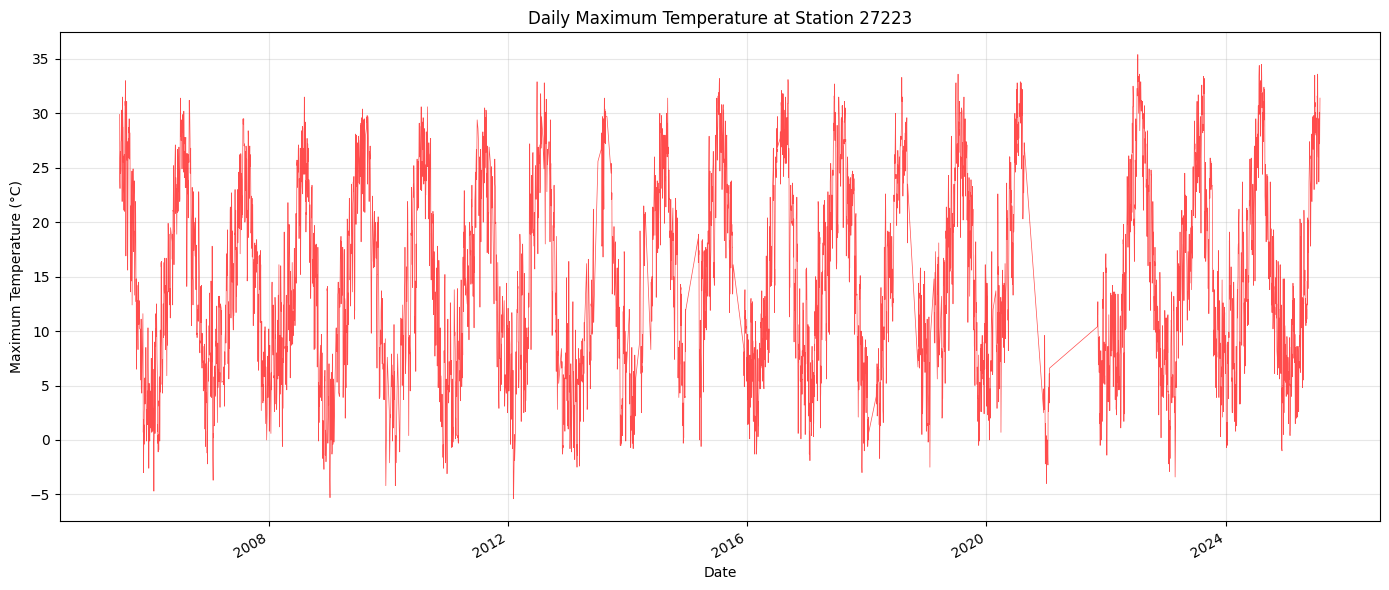

In [164]:
plt.figure(figsize=(14, 6))
tx_timeseries.plot(color='red', linewidth=0.5, alpha=0.7)
plt.title(f"Daily Maximum Temperature at Station {selected_station_STAID}")
plt.ylabel("Maximum Temperature (°C)")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Our answers for week 2

In [165]:
point=stations_in_city_gdf.loc[stations_in_city_gdf['STAID'] == 27223, 'geometry'].iloc[0]
longitude = point.x
latitude = point.y


In [166]:
ds_sel = ds[datavar].sel(latitude=latitude, longitude=longitude, method="nearest")
ds_sel_to_celsius = ds_sel - 273.15
era5_timed_series=ds_sel_to_celsius.to_series()


In [167]:
plt.figure(figsize=(14, 6))
start_date = '2020-01-01'
end_date = '2026-12-31'
tx_timeseries_filtered = tx_timeseries.loc[start_date:end_date]

<Figure size 1400x600 with 0 Axes>

# 1. Comparison using only one station

In [199]:
comparison_df = pd.DataFrame({
    'ERA5_TX': era5_timed_series,
    'Station_TX': tx_timeseries_filtered
}).dropna()

comparison_df['Discrepancy_TX'] = comparison_df['Station_TX']-comparison_df['ERA5_TX']

For our Comparison of discrepancies between datasets, we will use :

- Bias : the mean of errors.
- Mean Square Error : $$MSE=\frac{1}{N}\sum_{i=1}^Nerror^2$$.
- Correlation


In [200]:
bias = comparison_df['Discrepancy_TX'].mean()
mse = np.mean(comparison_df['Discrepancy_TX']**2)
corr = comparison_df['ERA5_TX'].corr(comparison_df['Station_TX'])

date_min = comparison_df.index.min().date()
date_max = comparison_df.index.max().date()
print(f"Comparison Period : {date_min} - {date_max}")
print(f"Number of measuring days: {len(comparison_df.notna())}")
print("=================================================")
print(f"Bias : {bias}")
print(f"MSE : {mse}")
print(f"Correlation coefficient : {corr}")

Comparison Period : 2020-01-01 - 2025-07-31
Number of measuring days: 1594
Bias : -0.2018406043537288
MSE : 2.2771149718007506
Correlation coefficient : 0.9869016700388673


We find out that the correlation is quite high, which suggests a good correlation between both station measure and ERA5 dataset.

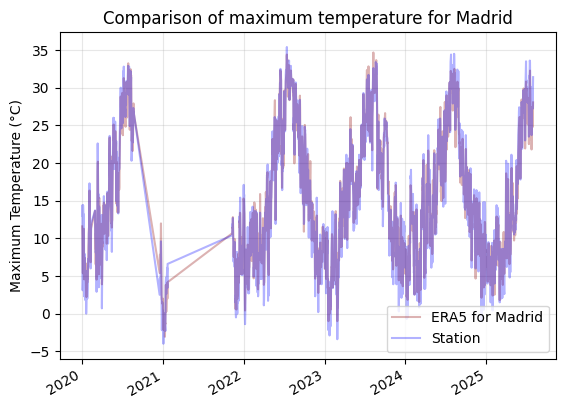

In [201]:
comparison_df['ERA5_TX'].plot(label='ERA5 for Madrid', color='darkred', alpha=0.3)
comparison_df['Station_TX'].plot(label=f"Station", color='blue', alpha=0.3)
plt.title(f"Comparison of maximum temperature for {cityname}")
plt.ylabel("Maximum Temperature (°C)")
plt.legend()
plt.grid(True, alpha=0.3)

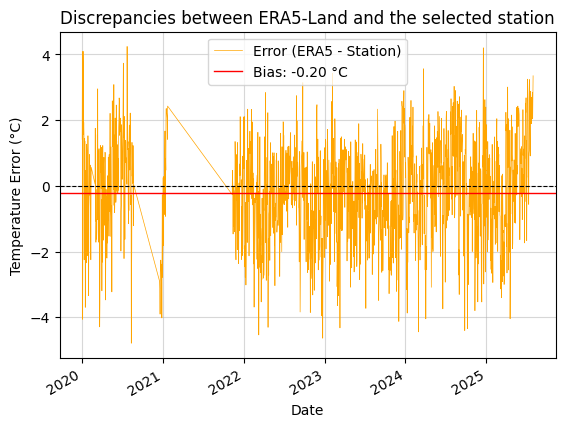

In [202]:
comparison_df['Discrepancy_TX'].plot(label='Error (ERA5 - Station)', color='orange', linewidth=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axhline(bias, color='red', linestyle='-', linewidth=1, label=f"Bias: {bias:.2f} °C")
plt.title(f"Discrepancies between ERA5-Land and the selected station")
plt.xlabel("Date")
plt.ylabel("Temperature Error (°C)")
plt.legend()
plt.grid(True, alpha=0.5)

The bias ($-0.20°C$) is negative and small, this means that the ERA5 model predicts temperatures that are slightly hotter than the reality. (We will verify later that this station is actually rural, which means that it doesn't contradict the UHI effect)

Note that the station didn't manage to measure the maximum temperature between 2021 and 2022 which may be due to a problem in their measuring system.

## Comparison of the discrepancies with the UHI effect

For this case, since the ndvi is by quarter and the discrepancies between ERA5-Land and the station is daily, we need to make the latter sorted by quarter.

In [172]:
def quarter(month):
    if 1<=month<=3:
        return 1
    elif 4<=month<=6:
        return 2
    elif 7<=month<=9:
        return 3
    return 4

In [216]:
"""Sorting the discrepancies by quarter"""
def transform_daily_into_quarter(discrepancies_daily):

    mean_discrepancies_by_quarter = pd.Series(dtype=float)
    valuesbyquarter = {}
    for date in discrepancies_daily.keys():
        year=date.year;month=date.month
        periodOfTime = quarter2timeperiod(year, quarter(month))
        new_date=pd.to_datetime(periodOfTime.split("_")[1])
        if new_date in mean_discrepancies_by_quarter.keys() and not np.isnan(discrepancies_daily[date]):
            valuesbyquarter[new_date].append(discrepancies_daily[date])
            mean_discrepancies_by_quarter[new_date]=np.mean(valuesbyquarter[new_date])
        elif new_date not in mean_discrepancies_by_quarter.keys() and not np.isnan(discrepancies_daily[date]):
            valuesbyquarter[new_date]=[discrepancies_daily[date]]
            mean_discrepancies_by_quarter[new_date]=discrepancies_daily[date]

    mean_discrepancies_by_quarter.sort_index()
    return mean_discrepancies_by_quarter

"""Restricting only to summer"""
def transform_daily_into_summer_only(discrepancies_daily):

    mean_discrepancies_by_quarter = pd.Series(dtype=float)
    valuesbyquarter = {}
    for date in discrepancies_daily.keys():
        year=date.year;month=date.month
        periodOfTime = quarter2timeperiod(year, quarter(month))
        new_date=pd.to_datetime(periodOfTime.split("_")[1])
        if quarter(month)==3:
            if new_date in mean_discrepancies_by_quarter.keys() and not np.isnan(discrepancies_daily[date]):
                valuesbyquarter[new_date].append(discrepancies_daily[date])
                mean_discrepancies_by_quarter[new_date]=np.mean(valuesbyquarter[new_date])
            elif new_date not in mean_discrepancies_by_quarter.keys() and not np.isnan(discrepancies_daily[date]):
                valuesbyquarter[new_date]=[discrepancies_daily[date]]
                mean_discrepancies_by_quarter[new_date]=discrepancies_daily[date]

    mean_discrepancies_by_quarter.sort_index()
    return mean_discrepancies_by_quarter
discrepancies_daily = comparison_df['Discrepancy_TX']
mean_discrepancies_by_quarter = transform_daily_into_quarter(discrepancies_daily)

In [217]:
for date in mean_ndvi_time_series.keys():
    if date not in mean_discrepancies_by_quarter.keys():
        mean_discrepancies_by_quarter[date]=np.nan

for date in mean_discrepancies_by_quarter.keys():
    if date not in mean_ndvi_time_series.keys():
        mean_ndvi_time_series[date]=np.nan

error_and_ndvi = pd.DataFrame({
    'Discrepancies': mean_discrepancies_by_quarter,
    'mean_ndvi': mean_ndvi_time_series
})


In [218]:
correlation = error_and_ndvi['Discrepancies'].corr(error_and_ndvi['mean_ndvi'])

print(correlation)

-0.023493591622220988


We find that the correlation is negative : $-0.023493591622220988$.

This isn't that surprising since the UHI effect consists in having a big bias for less NDVI.

# 2. Comparison with all stations

In [176]:
staids = stations_in_city_gdf["STAID"].unique()
num_stations = len(staids)
full_selected_stations={}
timed_series_stations={}
era5_timed_series_by_stations=pd.DataFrame({})

In [177]:
for staid in staids:
    point_i=stations_in_city_gdf.loc[stations_in_city_gdf['STAID'] == staid, 'geometry'].iloc[0]
    longitude_i = point_i.x
    latitude_i = point_i.y
    ds_sel_i = ds[datavar].sel(latitude=latitude_i, longitude=longitude_i, method="nearest")
    ds_sel_to_celsius_i = ds_sel_i - 273.15
    era5_timed_series_i=ds_sel_to_celsius_i.to_series()

    era5_timed_series_by_stations[staid]=era5_timed_series_i
station_cols = era5_timed_series_by_stations.columns
era5_timed_series_by_stations['Mean_stations'] = era5_timed_series_by_stations[station_cols].mean(axis=1)

era5_timed_series_by_stations.head()

,230,3839,3945,3946,3947,3948,27219,27221,27222,27223,...,27229,27230,27231,27232,27234,27238,27242,27244,27245,Mean_stations
valid_time,,,,,,,,,,,,,,,,,,,,,
2020-01-01,11.437592,11.612579,12.081329,11.648529,11.546967,11.162201,10.795013,10.929657,12.053986,11.582001,...,11.575470,11.117279,11.720795,11.546967,11.279388,12.231720,12.089935,12.307892,12.341095,11.649053
2020-01-02,9.301971,9.438141,9.705719,9.432281,9.346893,9.272675,9.163300,9.245514,10.140045,10.317780,...,9.426422,9.243378,9.451813,9.346893,9.462128,9.695953,9.891266,9.912750,9.713531,9.544270
2020-01-03,9.165497,8.638153,8.745575,9.136200,9.540497,8.974091,8.497528,7.035248,7.839935,7.162201,...,8.440887,8.401825,9.472137,9.540497,8.220184,8.716888,10.450653,10.343231,9.712372,8.883898
2020-01-04,10.441650,9.658447,8.115479,10.136963,10.467041,10.562744,10.263916,5.467041,6.215088,5.355713,...,9.402588,10.215088,10.265869,10.467041,9.734619,6.980713,9.750885,9.887604,8.863525,9.143907
2020-01-05,11.763184,11.747559,11.520996,11.940918,11.886230,11.429199,10.626465,9.441040,11.222290,10.302368,...,11.673340,11.228027,12.056152,11.886230,11.028809,10.917480,11.386230,11.720215,11.554199,11.395921


In [178]:
for i in range(num_stations):
    selected_station_i = stations_in_city_gdf.iloc[i]
    full_selected_stations[staids[i]] = gpd.GeoDataFrame([selected_station_i], crs=stations_in_city_gdf.crs)
    selected_station_STAID_i = selected_station_i['STAID']
    station_data_filepath_i = eca_tx_datafolder + f"TX_STAID{selected_station_STAID_i:06d}.txt"

    station_data_df_i = pd.read_csv(
        station_data_filepath_i,
        skiprows=20,
        skipinitialspace=True
    )

    valid_data_df_i = station_data_df_i[station_data_df_i['Q_TX'] == 0].copy() # Q_TX is the quality code for TX (0='valid')
    valid_data_df_i['DATE'] = pd.to_datetime(valid_data_df_i['DATE'], format='%Y%m%d')
    valid_data_df_i['TX_celsius'] = valid_data_df_i['TX'] / 10 # Convert temperature to °C (originally stored in 0.1°C unit)

    tx_timeseries_i = pd.Series(
        valid_data_df_i['TX_celsius'].values,
        index=valid_data_df_i['DATE']
    )
    timed_series_stations[staids[i]]=tx_timeseries_i



In [179]:
stations_df = pd.DataFrame({})
for staid in staids:
    stations_df[staid]=timed_series_stations[staid]
station_cols = stations_df.columns
stations_df['Mean_stations'] = stations_df[station_cols].mean(axis=1)

In [180]:
stations_df=stations_df.dropna()
stations_df.head()

,230,3839,3945,3946,3947,3948,27219,27221,27222,27223,...,27229,27230,27231,27232,27234,27238,27242,27244,27245,Mean_stations
DATE,,,,,,,,,,,,,,,,,,,,,
2012-02-19,13.4,14.6,11.7,15.0,14.4,14.8,15.0,10.7,10.0,5.5,...,15.1,15.7,15.0,15.0,14.3,15.3,12.0,13.7,13.6,13.400000
2012-02-22,14.6,16.2,13.0,16.3,15.5,16.2,16.1,14.1,13.7,9.0,...,16.5,17.3,16.8,16.6,15.6,15.6,13.5,15.2,14.3,14.995238
2012-02-26,20.4,21.3,18.8,22.0,21.0,21.5,22.4,17.8,16.7,11.7,...,22.3,22.7,22.0,22.2,21.5,18.9,18.2,19.8,20.6,20.138095
2012-02-27,18.8,19.0,16.9,20.2,20.0,20.2,20.9,17.8,17.5,14.7,...,20.5,20.4,19.8,20.6,20.1,20.9,17.5,19.1,19.5,19.066667
2012-02-28,18.6,19.7,17.0,20.9,19.5,20.2,21.5,17.3,16.2,15.5,...,20.8,21.7,20.2,20.4,20.9,19.7,17.5,19.5,19.0,19.204762


In [181]:
discreptancies_by_stations = pd.DataFrame({})
for staid in staids:
    discreptancies_by_stations[staid]=(stations_df[staid]-era5_timed_series_by_stations[staid]).dropna()
discreptancies_by_stations['Mean_stations']=stations_df['Mean_stations']-era5_timed_series_by_stations['Mean_stations']
discreptancies_by_stations.head()

,230,3839,3945,3946,3947,3948,27219,27221,27222,27223,...,27229,27230,27231,27232,27234,27238,27242,27244,27245,Mean_stations
2020-01-01,-0.237592,1.687421,0.218671,1.151471,1.953033,1.637799,1.704987,7.070343,3.246014,1.417999,...,2.024530,2.182721,1.979205,3.853033,1.320612,5.268280,1.910065,1.192108,1.558905,2.065233
2020-01-02,1.198029,2.761859,0.694281,3.467719,2.653107,3.127325,4.236700,6.454486,2.359955,4.082220,...,3.473578,3.056622,2.648187,3.753107,2.437872,4.704047,2.708734,1.887250,2.286469,2.993826
2020-01-03,-3.165497,-4.038153,-1.445575,-4.636200,-2.840497,-3.174091,-1.697528,4.764752,2.660065,-4.062201,...,-2.540887,-2.901825,-2.872137,-1.840497,-2.220184,0.783112,-3.050653,-2.643231,-2.212372,-2.145803
2020-01-04,0.758350,2.241553,1.584521,2.263037,1.432959,1.437256,2.836084,7.632959,5.084912,-1.255713,...,3.197412,2.684912,1.534131,2.132959,2.665381,3.919287,0.649115,0.712396,2.036475,2.217998
2020-01-05,-0.863184,-0.047559,1.479004,1.059082,1.613770,0.970801,1.073535,8.158960,5.977710,4.097632,...,1.026660,0.571973,1.243848,3.613770,0.771191,7.382520,1.313770,2.279785,2.745801,2.251698


## Calculate NDVI for each station area + the city

In [182]:
ndvi_stations_dict = {staid: [] for staid in stations_in_city_gdf['STAID']}
ndvi_dates = []

for year in available_years:
    for q in available_quarters:
        timeperiod = quarter2timeperiod(year, q)
        filepath = f"{ndvi_data_folder}ndvi_{timeperiod}.tif"
        
        current_date = pd.to_datetime(timeperiod.split("_")[1])
        ndvi_dates.append(current_date)
        
        with rasterio.open(filepath) as src:
            stations_projected = stations_in_city_gdf.to_crs(src.crs)
            
            coords = [(geom.x, geom.y) for geom in stations_projected.geometry]
            
            sampled_values = src.sample(coords)
            
            for staid, val in zip(stations_in_city_gdf['STAID'], sampled_values):
                raw_val = val[0] 
                
                if raw_val == src.nodata:
                    real_ndvi = np.nan
                else:
                    real_ndvi = (float(raw_val) / 254.0 * 2.0) - 1.0
                
                ndvi_stations_dict[staid].append(real_ndvi)
ndvi_stations_dict['Mean_stations']=mean_ndvi_time_series
ndvi_stations_df = pd.DataFrame(ndvi_stations_dict, index=ndvi_dates)
ndvi_stations_df = ndvi_stations_df.sort_index()

ndvi_stations_df.head()

,230,3839,3945,3946,3947,3948,27219,27221,27222,27223,...,27229,27230,27231,27232,27234,27238,27242,27244,27245,Mean_stations
2020-03-01,0.590551,0.818898,0.125984,0.700787,0.181102,0.401575,0.448819,0.566929,0.535433,0.551181,...,0.496063,0.251969,0.645669,0.212598,0.251969,0.023622,0.629921,0.338583,0.409449,0.485405
2020-06-01,0.503937,0.716535,0.118110,0.535433,0.149606,0.283465,0.440945,0.614173,0.622047,0.629921,...,0.346457,0.267717,0.551181,0.204724,0.212598,0.031496,0.661417,0.299213,0.519685,0.477942
2020-09-01,0.582677,0.220472,0.070866,0.181102,0.078740,0.118110,0.370079,0.370079,0.370079,0.566929,...,0.228346,0.228346,0.314961,0.228346,0.173228,0.023622,0.551181,0.133858,0.251969,0.328603
2020-12-01,0.590551,0.472441,0.102362,0.543307,0.110236,0.157480,0.409449,0.598425,0.456693,0.590551,...,0.283465,0.314961,0.511811,0.228346,0.212598,0.023622,0.606299,0.251969,0.433071,0.393353
2021-03-01,0.480315,0.637795,0.118110,0.653543,0.149606,0.196850,0.338583,0.299213,0.448819,0.346457,...,0.283465,0.133858,0.535433,0.173228,0.204724,0.039370,0.377953,0.212598,0.433071,0.368942


## Without any restriction

In [183]:
station_discreptancies_by_quarter = pd.DataFrame({})
for staid in staids:
    station_discreptancies_by_quarter[staid]=transform_daily_into_quarter(discreptancies_by_stations[staid])
station_discreptancies_by_quarter['Mean_stations']=transform_daily_into_quarter(discreptancies_by_stations['Mean_stations'])

station_discreptancies_by_quarter.head()

,230,3839,3945,3946,3947,3948,27219,27221,27222,27223,...,27229,27230,27231,27232,27234,27238,27242,27244,27245,Mean_stations
2020-03-01,-0.031956,1.055461,-0.378157,1.333767,0.752138,0.507897,1.611813,4.617910,2.189812,-0.272971,...,1.799363,1.331406,0.717705,1.107694,1.250319,3.534250,-1.032164,-0.168427,0.346457,1.023505
2020-06-01,0.725781,1.945519,-0.223270,2.349689,1.318142,0.970254,1.880451,4.744532,1.883920,-0.315440,...,2.440427,1.999559,1.562050,1.353142,1.988264,3.780429,-0.715566,-0.249782,0.185868,1.415838
2020-09-01,-0.059874,1.516615,-0.255422,2.062318,1.443334,0.962157,0.896992,4.473071,1.700148,-0.043726,...,2.118016,1.656187,0.448646,1.383334,1.324492,2.884634,0.224037,-0.170885,0.528763,1.166511
2020-12-01,-0.827890,-1.137561,-1.639252,-0.934045,-0.985507,-1.259726,-1.519882,2.533405,0.531500,-3.261664,...,-0.175061,-1.153085,-0.274866,-0.485507,-1.042734,1.182233,-1.617892,-0.974554,-1.075336,-0.773998
2021-12-01,0.674965,2.252197,1.337363,2.108027,1.984828,1.760194,2.510160,5.165492,3.405802,-0.175787,...,2.902165,2.796718,0.832263,2.610754,2.104545,4.620306,0.186094,1.261780,1.844120,2.095596


In [184]:
correlations= {}
bias = {}
mse = {}
std = {}
ci = {}
# 1.96* (std/np.sqrt(len(df)))

for staid in staids:
    bias[staid]= discreptancies_by_stations[staid].mean()
    mse[staid]= np.mean(discreptancies_by_stations[staid]**2)
    std[staid] = discreptancies_by_stations[staid].std() 
    ci[staid]=1.96 * (std[staid]/np.sqrt(len(discreptancies_by_stations[staid])))
    correlations[staid]= station_discreptancies_by_quarter[staid].corr(ndvi_stations_df[staid])
bias['Mean_stations']= discreptancies_by_stations[staid].mean()
mse['Mean_stations']= np.mean(discreptancies_by_stations[staid]**2)
std['Mean_stations'] = discreptancies_by_stations[staid].std() 
correlations['Mean_stations']= station_discreptancies_by_quarter[staid].corr(ndvi_stations_df['Mean_stations'])
ci['Mean_stations']=1.96 * (std['Mean_stations']/np.sqrt(len(discreptancies_by_stations['Mean_stations'])))

correlations['Mean_stations']= station_discreptancies_by_quarter['Mean_stations'].corr(mean_ndvi_time_series)
correlation_with_ndvi = pd.DataFrame([bias, correlations, mse, std, ci])
correlation_with_ndvi.index = ['Bias', 'Correlation with NDVI', 'MSE', 'STD', 'CI']
correlation_with_ndvi.head()

,230,3839,3945,3946,3947,3948,27219,27221,27222,27223,...,27229,27230,27231,27232,27234,27238,27242,27244,27245,Mean_stations
Bias,0.294517,1.904889,0.195731,1.893727,1.112443,0.976651,1.770086,4.772084,2.347434,-0.254246,...,2.472451,2.119043,0.854261,1.497422,1.864654,3.943321,-0.483170,-0.074671,0.587284,0.587284
Correlation with NDVI,-0.569489,0.003507,0.128108,-0.276982,-0.036028,-0.072768,-0.220213,-0.054258,0.169111,-0.062770,...,-0.047995,-0.159013,-0.171129,0.113891,-0.210422,0.452131,-0.365261,0.131104,0.078879,0.050868
MSE,1.361402,5.161676,1.565265,5.153385,2.479725,2.165783,4.615536,25.341271,7.277936,2.221791,...,7.608929,6.286709,2.349425,4.122745,4.727524,18.123083,2.117411,1.280564,1.878677,1.878677
STD,1.129774,1.239012,1.236537,1.252719,1.115294,1.101626,1.218334,1.603735,1.330371,1.469719,...,1.223905,1.341193,1.273521,1.372232,1.119055,1.605237,1.373503,1.129918,1.239295,1.239295
CI,0.081456,0.089333,0.089154,0.090321,0.080412,0.079427,0.087842,0.115629,0.095919,0.105966,...,0.088243,0.096700,0.091821,0.098938,0.080684,0.115737,0.099029,0.081467,0.089353,0.089353


We have a very bad correlation when we don't restrict the data temporally. This means that the UHI effect may actually be more important in a part of the year. (Summer)

## Metrics by seasons

In [186]:
all_errors = []

for staid in staids:
    if staid in discreptancies_by_stations.columns:
        temp_df = pd.DataFrame({
            'Error': discreptancies_by_stations[staid],
            'Station': staid,
            'Date': discreptancies_by_stations.index
        })
        if staid in ndvi_stations_df.columns:
            ndvi_aligned = ndvi_stations_df[staid].reindex(temp_df['Date'], method='ffill')
            temp_df['NDVI'] = ndvi_aligned
        
        all_errors.append(temp_df)

df_analysis = pd.concat(all_errors)
df_analysis['Month'] = df_analysis['Date'].dt.month

def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'

df_analysis['Season'] = df_analysis['Month'].apply(get_season)


seasonal_metrics = df_analysis.groupby('Season')['Error'].agg(['mean', 'std', 'count'])
seasonal_metrics['RMSE'] = df_analysis.groupby('Season')['Error'].apply(lambda x: (x**2).mean())
seasonal_metrics.columns = ['Bias (Mean Error)', 'STD', 'Count', 'MSE']

print("Metrics by season :")
print(seasonal_metrics)

Metrics by season :
        Bias (Mean Error)       STD  Count       MSE
Season                                              
Autumn           1.290991  1.832764   2646  5.024414
Spring           1.342403  1.774480   3654  4.949962
Summer           1.636627  1.686621   4137  5.522552
Winter           1.384722  1.964073   5082  5.774281


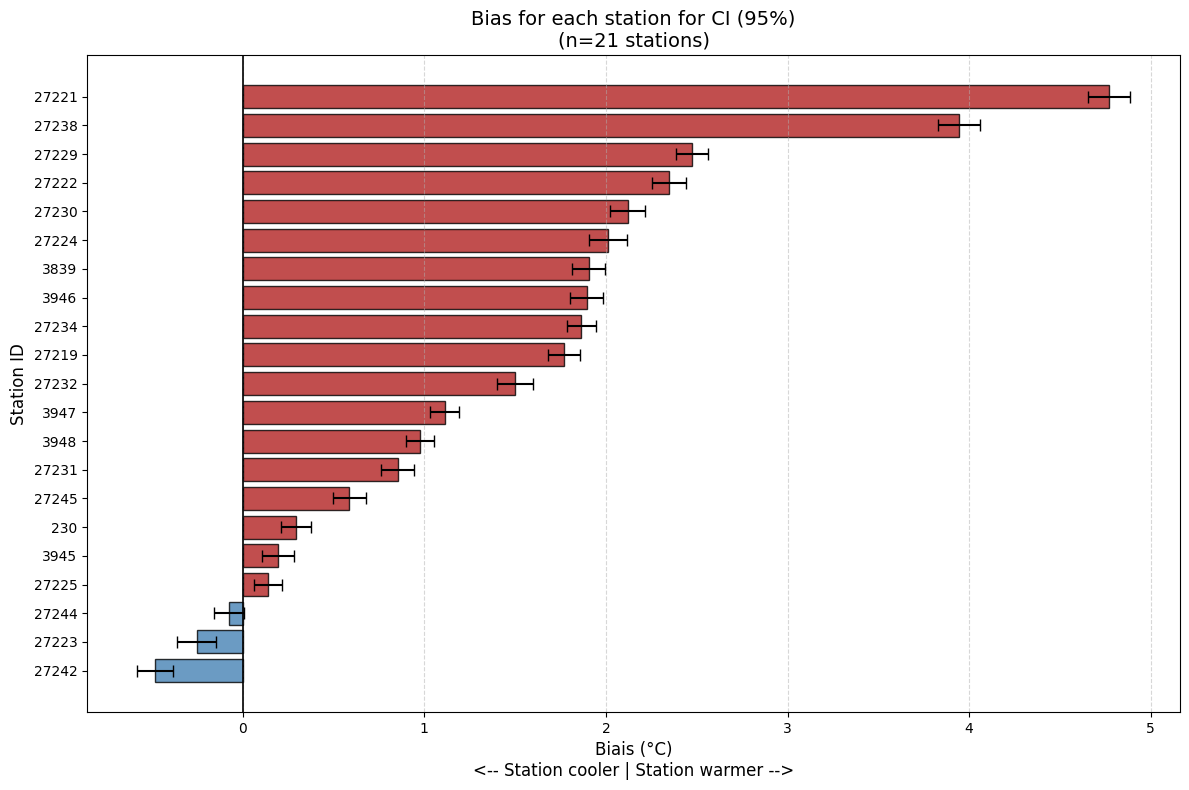

In [195]:
import matplotlib.pyplot as plt

stats_transposed = correlation_with_ndvi.T

stats_clean = stats_transposed.drop('Mean_stations', errors='ignore')
stats_sorted = stats_clean.sort_values(by='Bias')

plt.figure(figsize=(12, 8))

# Sort by bias value
colors = ['firebrick' if x > 0 else 'steelblue' for x in stats_sorted['Bias']]

plt.barh(stats_sorted.index.astype(str), stats_sorted['Bias'], 
         xerr=stats_sorted['CI'],  
         capsize=4,                
         color=colors, alpha=0.8, edgecolor='black')

plt.axvline(0, color='black', linestyle='-', linewidth=1.2) # Ligne zéro
plt.title(f'Bias for each station for CI (95%)\n(n={len(stats_sorted)} stations)', fontsize=14)
plt.xlabel('Biais (°C)\n<-- Station cooler | Station warmer -->', fontsize=12)
plt.ylabel('Station ID', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

C:\Users\moham\AppData\Local\Temp\ipykernel_42716\4233728628.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_analysis, x='Station', y='Error', palette="viridis")


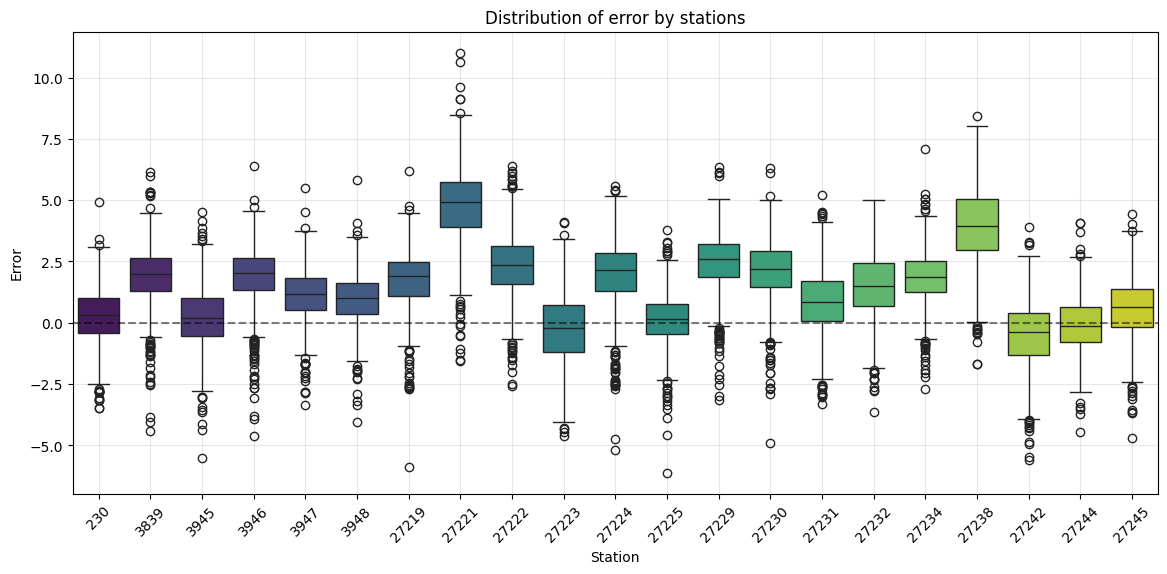

In [219]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_analysis, x='Station', y='Error', palette="viridis")
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title("Distribution of error by stations")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

We see that the stations are almost always warmer than the ERA5-Land model except stations : 27244, 27223 and 27242. 

Let's see the nature of these stations (rural/urban)

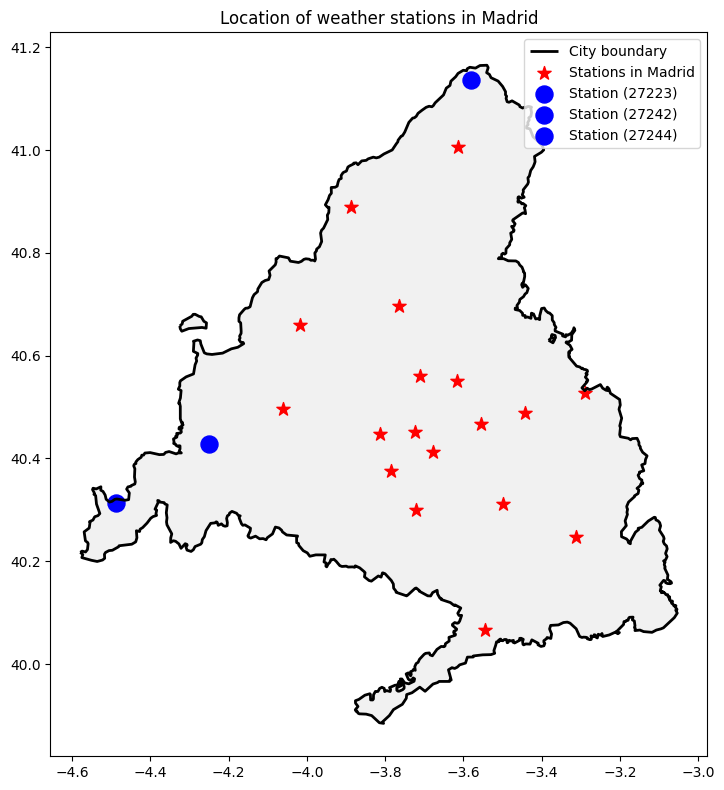

In [198]:
selected_station = stations_in_city_gdf.iloc[9]
selected_station2 = stations_in_city_gdf.iloc[18]
selected_station3 = stations_in_city_gdf.iloc[19]

selected_station_gdf = gpd.GeoDataFrame([selected_station], crs=stations_in_city_gdf.crs)
selected_station_STAID = selected_station['STAID']
selected_station_gdf2 = gpd.GeoDataFrame([selected_station2], crs=stations_in_city_gdf.crs)
selected_station_STAID2 = selected_station2['STAID']
selected_station_gdf3 = gpd.GeoDataFrame([selected_station3], crs=stations_in_city_gdf.crs)
selected_station_STAID3 = selected_station3['STAID']

fig, ax = plt.subplots(figsize=(10, 8))

one_city_gdf.boundary.plot(ax=ax, color='black', linewidth=2, label='City boundary')
one_city_gdf.plot(ax=ax, alpha=0.3, color='lightgray')

stations_in_city_gdf.plot(ax=ax, color='red', markersize=100, marker='*', label=f'Stations in {cityname}')
selected_station_gdf.plot(ax=ax, color='blue', markersize=150, marker='o', label=f'Station ({selected_station_STAID})')
selected_station_gdf2.plot(ax=ax, color='blue', markersize=150, marker='o', label=f'Station ({selected_station_STAID2})')
selected_station_gdf3.plot(ax=ax, color='blue', markersize=150, marker='o', label=f'Station ({selected_station_STAID3})')

plt.legend()
plt.title(f"Location of weather stations in {cityname}")
plt.tight_layout()
plt.show()

As we see here, the three stations are far from the center of the city, which makes it legitimate to conclude that they are in the rural areas.

(It explains why in our "one station" case, we had a positive correlation)

C:\Users\moham\AppData\Local\Temp\ipykernel_42716\1425377870.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_analysis, x='Season', y='Error', inner="quartile", palette="coolwarm")


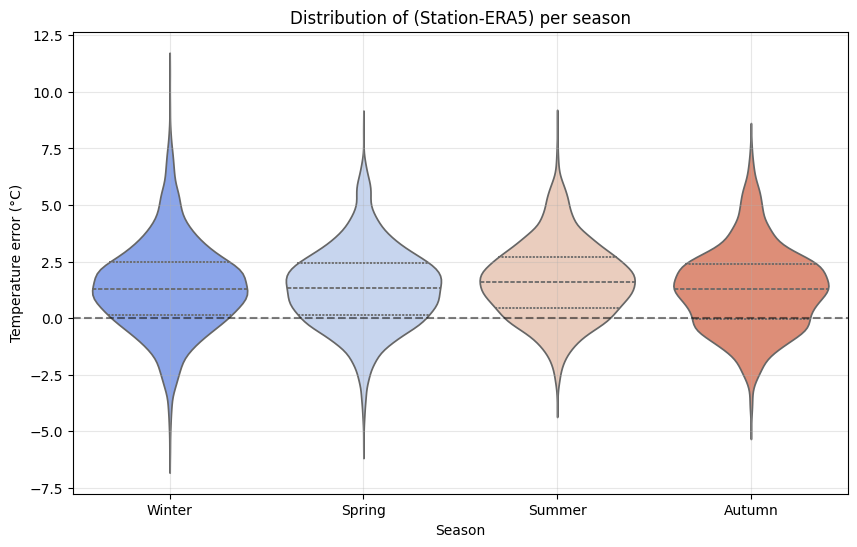

In [189]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_analysis, x='Season', y='Error', inner="quartile", palette="coolwarm")
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title("Distribution of (Station-ERA5) per season")
plt.ylabel("Temperature error (°C)")
plt.grid(True, alpha=0.3)
plt.show()

We see that the bias (mean of discrepancies) is slightly bigger in the summer than the other seasons. This has given us the idea to restrict the study only to summer for the potential UHI effect.

             Bias      RMSE  Mean_NDVI  HGHT        Lat       Lon
Station                                                          
230      0.294517  1.166791   0.535713   667  40.411667 -3.678056
3839     1.904889  2.271932   0.531345   607  40.488333 -3.443333
3945     0.195731  1.251105   0.103135  1004  40.695833 -3.765000
3946     1.893727  2.270107   0.512875   609  40.466667 -3.555556
3947     1.112443  1.574714   0.133925   690  40.375556 -3.785833


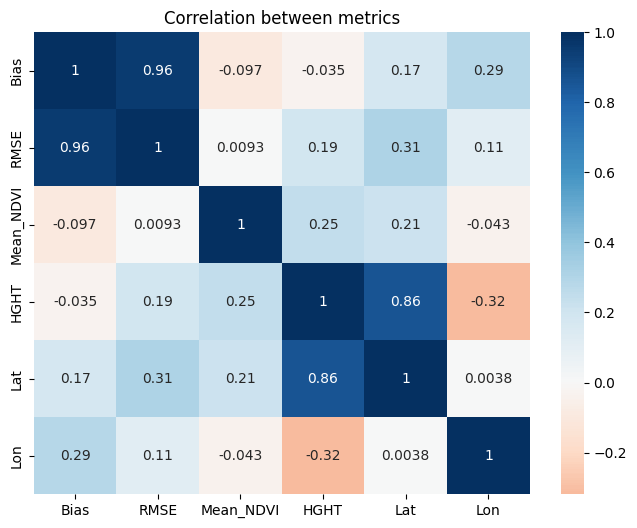

In [191]:
station_meta = stations_gdf[['STAID', 'HGHT']].set_index('STAID')

station_meta['Lat'] = stations_gdf.geometry.y.values
station_meta['Lon'] = stations_gdf.geometry.x.values

station_perf = df_analysis.groupby('Station').agg({
    'Error': ['mean', lambda x: np.sqrt((x**2).mean())], # Bias et RMSE
    'NDVI': 'mean' # NDVI moyen sur la période
})
station_perf.columns = ['Bias', 'RMSE', 'Mean_NDVI']
explanatory_df = station_perf.join(station_meta)
print(explanatory_df.head())

plt.figure(figsize=(8, 6))
sns.heatmap(explanatory_df.corr(), annot=True, cmap='RdBu', center=0)
plt.title("Correlation between metrics")
plt.show()

## With restriction on summer

In [192]:
station_discreptancies_by_quarter = pd.DataFrame({})
for staid in staids:
    station_discreptancies_by_quarter[staid]=transform_daily_into_summer_only(discreptancies_by_stations[staid])
station_discreptancies_by_quarter['Mean_stations']=transform_daily_into_summer_only(discreptancies_by_stations['Mean_stations'])

station_discreptancies_by_quarter.head()

,230,3839,3945,3946,3947,3948,27219,27221,27222,27223,...,27229,27230,27231,27232,27234,27238,27242,27244,27245,Mean_stations
2020-09-01,-0.059874,1.516615,-0.255422,2.062318,1.443334,0.962157,0.896992,4.473071,1.700148,-0.043726,...,2.118016,1.656187,0.448646,1.383334,1.324492,2.884634,0.224037,-0.170885,0.528763,1.166511
2022-09-01,0.682788,2.113119,0.411201,2.211947,1.325872,1.171393,2.073969,5.071255,2.124364,0.216477,...,2.925474,2.498100,1.129858,1.685549,2.143086,4.001446,0.277161,0.085634,0.721700,1.669732
2023-09-01,0.304591,1.824980,-0.200429,2.058063,0.720154,0.620525,1.286570,4.580308,1.978623,-0.791215,...,2.337402,2.179054,0.909451,1.273184,1.937969,3.488820,-0.876064,-0.697475,0.443411,1.190822
2025-09-01,0.912509,2.443709,0.557197,2.513803,1.255059,1.141543,1.443085,5.321988,2.540896,1.850428,...,3.083213,3.177548,1.694595,1.220576,2.497640,4.052555,-0.213471,-0.190671,1.035203,1.865077


In [194]:
correlations= {}
bias = {}
mse = {}
std = {}
ci = {}
# 1.96* (std/np.sqrt(len(df)))

for staid in staids:
    bias[staid]= discreptancies_by_stations[staid].mean()
    mse[staid]= np.mean(discreptancies_by_stations[staid]**2)
    std[staid] = discreptancies_by_stations[staid].std() 
    ci[staid]=1.96 * (std[staid]/np.sqrt(len(discreptancies_by_stations[staid])))
    correlations[staid]= station_discreptancies_by_quarter[staid].corr(ndvi_stations_df[staid])
bias['Mean_stations']= discreptancies_by_stations[staid].mean()
mse['Mean_stations']= np.mean(discreptancies_by_stations[staid]**2)
std['Mean_stations'] = discreptancies_by_stations[staid].std() 
correlations['Mean_stations']= station_discreptancies_by_quarter[staid].corr(ndvi_stations_df['Mean_stations'])
ci['Mean_stations']=1.96 * (std['Mean_stations']/np.sqrt(len(discreptancies_by_stations['Mean_stations'])))

correlations['Mean_stations']= station_discreptancies_by_quarter['Mean_stations'].corr(mean_ndvi_time_series)
correlation_with_ndvi = pd.DataFrame([bias, correlations, mse, std, ci])
correlation_with_ndvi.index = ['Bias', 'Correlation bias with NDVI', 'MSE', 'STD', 'CI']
correlation_with_ndvi.head()

C:\Users\moham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:3063: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\moham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:3064: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,230,3839,3945,3946,3947,3948,27219,27221,27222,27223,...,27229,27230,27231,27232,27234,27238,27242,27244,27245,Mean_stations
Bias,0.294517,1.904889,0.195731,1.893727,1.112443,0.976651,1.770086,4.772084,2.347434,-0.254246,...,2.472451,2.119043,0.854261,1.497422,1.864654,3.943321,-0.483170,-0.074671,0.587284,0.587284
Correlation bias with NDVI,-0.535722,-0.780314,-0.705191,-0.300593,-0.988483,NaN,-0.656615,-0.488929,-0.706551,-0.285775,...,-0.704241,-0.968348,-0.948413,0.259684,NaN,0.235199,-0.885704,-0.885496,-0.525303,-0.654610
MSE,1.361402,5.161676,1.565265,5.153385,2.479725,2.165783,4.615536,25.341271,7.277936,2.221791,...,7.608929,6.286709,2.349425,4.122745,4.727524,18.123083,2.117411,1.280564,1.878677,1.878677
STD,1.129774,1.239012,1.236537,1.252719,1.115294,1.101626,1.218334,1.603735,1.330371,1.469719,...,1.223905,1.341193,1.273521,1.372232,1.119055,1.605237,1.373503,1.129918,1.239295,1.239295
CI,0.081456,0.089333,0.089154,0.090321,0.080412,0.079427,0.087842,0.115629,0.095919,0.105966,...,0.088243,0.096700,0.091821,0.098938,0.080684,0.115737,0.099029,0.081467,0.089353,0.089353


We found out that correlation with NDVI during summer is very important and negative (and the bias is positive except for our 3 exceptions in the rural part), this confirms that the UHI effect is important during summer and it is the main responsible for this discrepancies between ERA5-Land model and the stations measures.

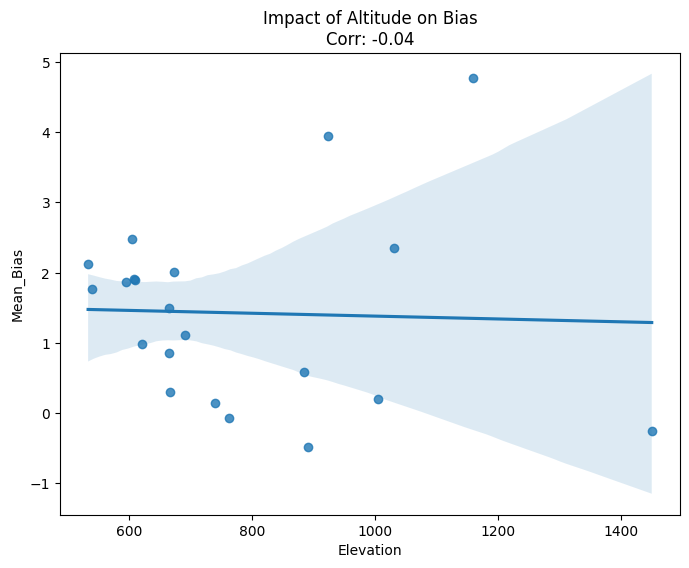

In [226]:
mean_bias_per_station = correlation_with_ndvi.loc['Bias'].drop('Mean_stations')

mean_ndvi_per_station = ndvi_stations_df.drop(columns=['Mean_stations']).mean()

spatial_analysis = pd.DataFrame({
    'Mean_Bias': mean_bias_per_station,
    'Mean_NDVI': mean_ndvi_per_station
})
if 'HGHT' in stations_in_city_gdf.columns:
    station_elevations = stations_in_city_gdf.set_index('STAID')['HGHT']
    
    spatial_analysis['Elevation'] = station_elevations
    
    elev_corr = spatial_analysis['Mean_Bias'].corr(spatial_analysis['Elevation'])
    
    plt.figure(figsize=(8, 6))
    sns.regplot(x='Elevation', y='Mean_Bias', data=spatial_analysis)
    plt.title(f"Impact of Altitude on Bias\nCorr: {elev_corr:.2f}")
    plt.show()

We see that the altitude doesn't have much effect on our dicrepancies between the datasets. So the UHI effect on summer is the main responsible for these discrepancies.

## Conclusion



The study confirms that the discrepancies between the ERA5-Land model and local station measurements in Madrid are largely driven by the Urban Heat Island (UHI) effect.While ERA5 provides accurate regional estimates, its coarse resolution prevents it from capturing local urban heating phenomena. This results in a systematic underestimation of maximum temperatures in built-up areas (low NDVI), particularly during the summer. Conversely, the model performs significantly better in rural areas where the UHI effect is negligible. Consequently, NDVI and Seasonality have been identified as critical explanatory variables to model and correct these discrepancies in future steps.
